# The Price is Right

Today we build a more complex solution for estimating prices of goods.

1. Day 2.0 notebook: create a RAG database with our 400,000 training data
2. Day 2.1 notebook: visualize in 2D
3. Day 2.2 notebook: visualize in 3D
4. Day 2.3 notebook: build and test a RAG pipeline with GPT-4o-mini
5. Day 2.4 notebook: (a) bring back our Random Forest pricer (b) Create a Ensemble pricer that allows contributions from all the pricers

Phew! That's a lot to get through in one day!

## PLEASE NOTE:

We already have a very powerful product estimator with our proprietary, fine-tuned LLM. Most people would be very satisfied with that! The main reason we're adding these extra steps is to deepen your expertise with RAG and with Agentic workflows.

## Finishing off with Random Forests & Ensemble

In [1]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from items import Item
from testing import Tester
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib


In [2]:
# CONSTANTS

QUESTION = "How much does this cost to the nearest dollar?\n\n"
DB = "products_vectorstore"

In [3]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [4]:
# Load in the test pickle file:

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [5]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [6]:
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
prices = [metadata['price'] for metadata in result['metadatas']]

# Random Forest

We will now train a Random Forest model.

Can you spot the difference from what we did in Week 6? In week 6 we used the word2vec model to form vectors; this time we'll use the vectors we already have in Chroma, from the SentenceTransformer model.

In [9]:
type(vectors)

numpy.ndarray

In [10]:
vectors.shape, vectors.size, vectors.nbytes, vectors.dtype


((400000, 384), 153600000, 1228800000, dtype('float64'))

In [11]:
vectors = vectors.astype(np.float32)

In [12]:
vectors.dtype

dtype('float32')

In [13]:
type(prices), len(prices), prices[0:10]

(list,
 400000,
 [226.95, 506.98, 405.0, 1.95, 246.93, 75.99, 144.95, 174.99, 349.95, 52.99])

# Take 3 hours for the next RF model training

In [14]:
##### This next line takes an hour on my M1 Mac!

# rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=4)
rf_model.fit(vectors, prices)

RandomForestRegressor(max_depth=15, n_jobs=4, random_state=42)

In [15]:
# Save the model to a file

joblib.dump(rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [16]:
# Load it back in again

rf_model = joblib.load('random_forest_model.pkl')

In [17]:
from agents.specialist_agent import SpecialistAgent
from agents.frontier_agent import FrontierAgent
from agents.random_forest_agent import RandomForestAgent

In [18]:
specialist = SpecialistAgent()
frontier = FrontierAgent(collection)
random_forest = RandomForestAgent()

In [19]:
def description(item):
    return item.prompt.split("to the nearest dollar?\n\n")[1].split("\n\nPrice is $")[0]

In [20]:
def rf(item):
    return random_forest.price(description(item))

1: Guess: $261.20 Truth: $374.41 Error: $113.21 SLE: 0.13 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $193.36 Truth: $225.11 Error: $31.75 SLE: 0.02 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $230.92 Truth: $61.68 Error: $169.24 SLE: 1.71 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $307.65 Truth: $599.99 Error: $292.34 SLE: 0.44 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $206.02 Truth: $16.99 Error: $189.03 SLE: 5.97 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $74.87 Truth: $31.99 Error: $42.88 SLE: 0.69 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $254.62 Truth: $101.79 Error: $152.83 SLE: 0.83 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $237.54 Truth: $289.00 Error: $51.46 SLE: 0.04 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $309.53 Truth: $635.86 Error: $326.33 SLE: 0.52 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $214.01 Truth: $65.99 Error: $148.02 SL

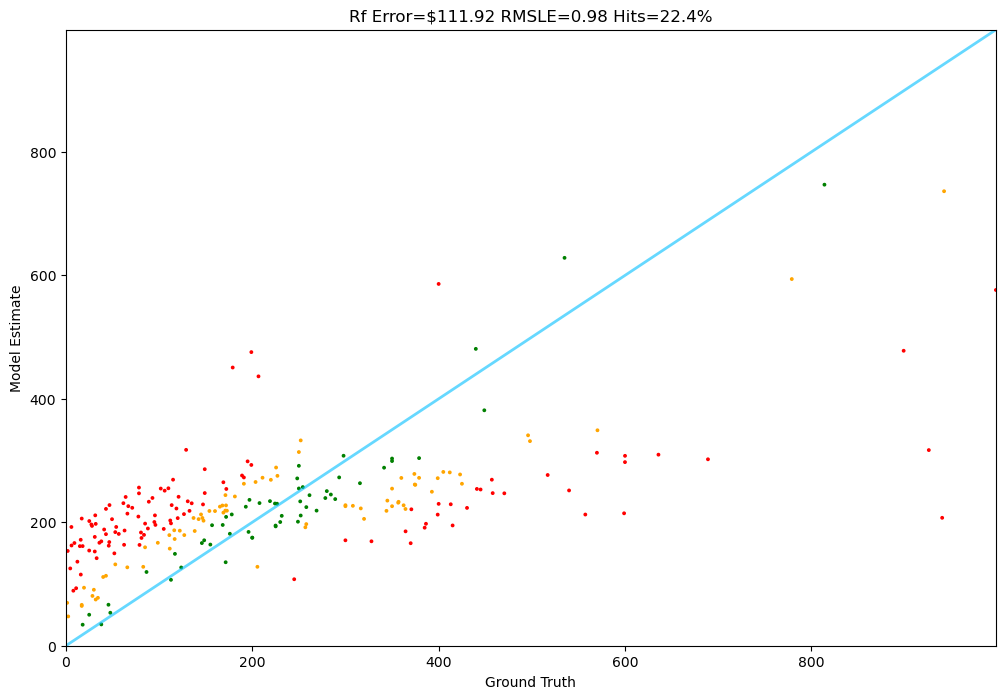

In [21]:
Tester.test(rf, test)

In [22]:
product = "Quadcast HyperX condenser mic for high quality audio for podcasting"

In [23]:
print(specialist.price(product))
print(frontier.price(product))
print(random_forest.price(product))

189.0
195.19
268.0122062517977


In [24]:
specialists = []
frontiers = []
random_forests = []
prices = []
for item in tqdm(test[1000:1250]):
    text = description(item)
    specialists.append(specialist.price(text))
    frontiers.append(frontier.price(text))
    random_forests.append(random_forest.price(text))
    prices.append(item.price)

100%|█████████████████████████████████████████████████████████████████| 250/250 [11:18<00:00,  2.72s/it]


In [35]:
mins = [min(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]
maxes = [max(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]

X = pd.DataFrame({
    'Specialist': specialists,
    'Frontier': frontiers,
    'RandomForest': random_forests,
    'Min': mins,
    'Max': maxes,
})

# Convert y to a Series
y = pd.Series(prices)

In [36]:
len(y)

250

In [37]:
type(X), X.shape

(pandas.core.frame.DataFrame, (250, 5))

In [38]:
# Train a Linear Regression
np.random.seed(42)

lr = LinearRegression()
lr.fit(X, y)

feature_columns = X.columns.tolist()

for feature, coef in zip(feature_columns, lr.coef_):
    print(f"{feature}: {coef:.2f}")
print(f"Intercept={lr.intercept_:.2f}")

Specialist: 0.59
Frontier: 0.20
RandomForest: -0.25
Min: 0.27
Max: 0.17
Intercept=26.79


In [39]:
joblib.dump(lr, 'ensemble_model.pkl')

['ensemble_model.pkl']

In [40]:
from agents.ensemble_agent import EnsembleAgent
ensemble = EnsembleAgent(collection)

In [41]:
ensemble.price(product)

206.24410913021887

In [42]:
def ensemble_pricer(item):
    return max(0,ensemble.price(description(item)))

1: Guess: $405.86 Truth: $374.41 Error: $31.45 SLE: 0.01 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $207.40 Truth: $225.11 Error: $17.71 SLE: 0.01 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $44.83 Truth: $61.68 Error: $16.85 SLE: 0.10 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $404.26 Truth: $599.99 Error: $195.73 SLE: 0.16 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $31.52 Truth: $16.99 Error: $14.53 SLE: 0.35 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $38.34 Truth: $31.99 Error: $6.35 SLE: 0.03 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $117.60 Truth: $101.79 Error: $15.81 SLE: 0.02 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $354.26 Truth: $289.00 Error: $65.26 SLE: 0.04 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $872.04 Truth: $635.86 Error: $236.18 SLE: 0.10 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $68.04 Truth: $65.99 Error: $2.05 SLE: 0.00 It

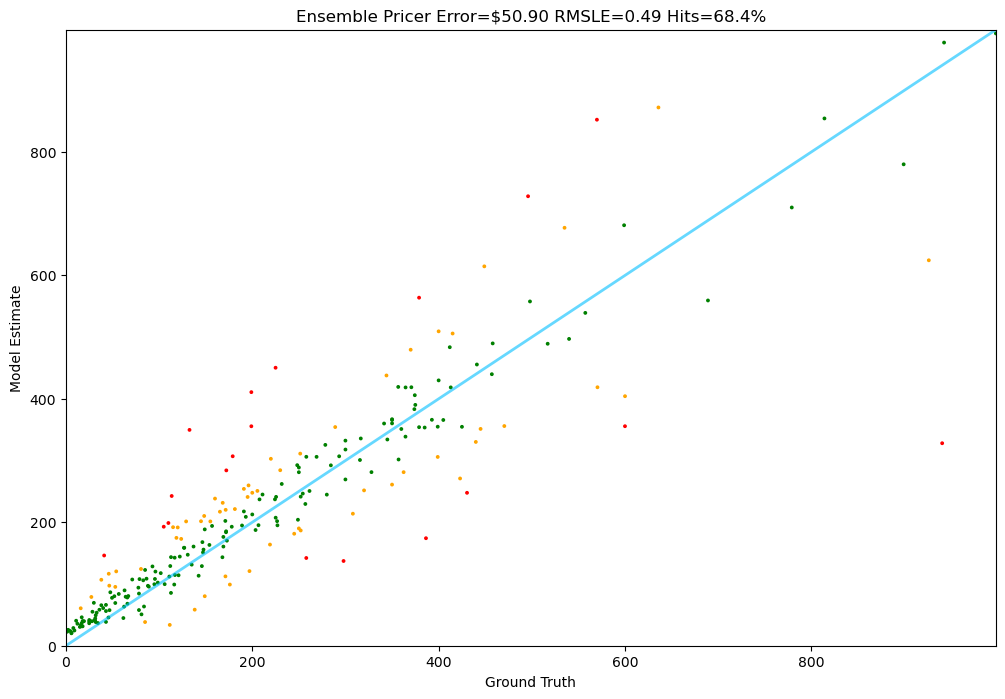

In [43]:
Tester.test(ensemble_pricer, test)

# WHAT A DAY!

We got so much done - a Fronter RAG pipeline, a Random Forest model using transformer-based encodings, and an Ensemble model.

You can do better, for sure!

Tweak this, and try adding components into the ensemble, to beat my performance.